# Diseño a cortante en vigas

In [510]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calcule el esfuerzo cortante factorizado, Vu, a partir de las fuerzas aplicadas que actúan sobre el elemento estructural. 
#    El valor crítico del esfuerzo cortante de cálculo se encuentra en una sección situada a una distancia d de la cara del apoyo.

Vu = 39.833 #Tonf

# 2. Revisión de limites de sección.

Para el $A_{v,min}$, Verificar si se cumple:

\begin{align*}
Vu > 0,27 \phi \lambda \sqrt{f'_{c}} \ b_{w} \ d
\end{align*}

In [511]:
phi = 0.75
lmbd = 1  #Para hormigón de densidad mayor a 2160 kgf/m3 (Ver ACI 19.2.4.1).
fc = 240 #kgf/cm2
rec = 4 #cm
destribo = 1.2 #cm
dvar = 2.4 #cm
h = 50 #cm
bw = 35 #cm
d = h - rec - destribo - (0.5*dvar) #cm

if (Vu*1000) > (0.27*phi*lmbd*np.sqrt(fc)*bw*d):
    print(f'Vu es menor (0.27*... = {0.27*phi*lmbd*np.sqrt(fc)*bw*d*0.001} < {Vu}), por tanto, utilizar tabla 9.6.3.4')
else:
    print(f'Vu es mayor, (0.27*... = {0.27*phi*lmbd*np.sqrt(fc)*bw*d*0.001} > {Vu}),  por tanto, utilizar tabla 9.6.3.1')

Vu es menor (0.27*... = 4.78723979491314 < 39.833), por tanto, utilizar tabla 9.6.3.4


Si en caso, no cumple, utilizar la tabla 9.6.3.1 de la ACI.

<img src='./Images/Cortante1.PNG'>

Si en caso, cumple, utilizar la tabla 9.6.3.4 de la ACI.

<img src='./Images/Cortante2.PNG'>

#### Equivalencias

<img src='./Images/Cortante3.PNG'>

In [512]:
# Calculo del Avmin

s = 10 #cm
fyt = 4200 #kgf/cm2, Límite elástico MAXIMO permisible especificado de la armadura transversal
Avmin = max(((0.2*np.sqrt(fc)*bw*s/fyt),(3.5*(bw*s)/fyt)))
print(f'Avmin = {Avmin} cm2')

Avmin = 0.2916666666666667 cm2


## Calculo de acero requerido

Utilizamos la ACI 22.5.5.1

<img src='./Images/Cortante4.PNG'>

#### Equivalencias

<img src='./Images/Cortante5.PNG'>

## Calculadora de Vigas

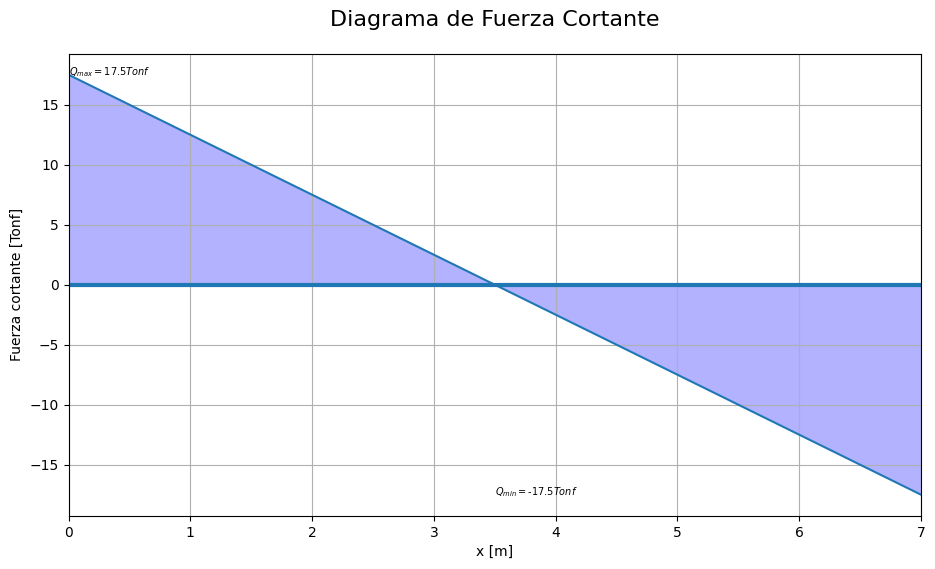

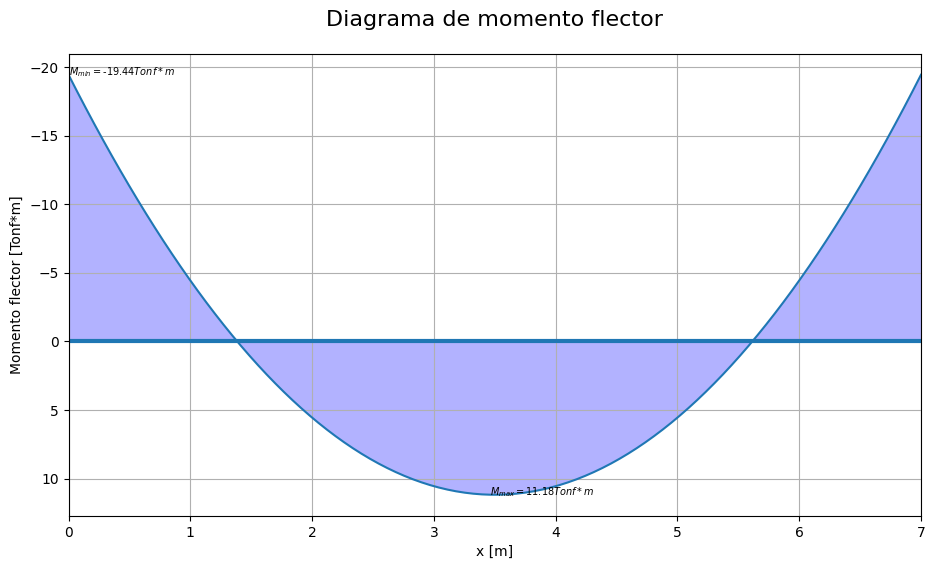

,0
0,17.500000
1,17.146465
2,16.792929
3,16.439394
4,16.085859
...,...
95,-16.085859
96,-16.439394
97,-16.792929
98,-17.146465


In [513]:
import graficadorVigas
import VigaContinua as VC


#Definimos los tramos de la viga continua en una lista
# VigaB(Elasticidad, Inercia, Longitud) por cada tramo
E = 2000000 #T/m2
I = 3.6e-3 #m4
Tramo = [VC.VigaB(E, I, 7)]


#Cargas en cada tramo
#q = CargaDistribuida(valor, inicio, longitud), el inicio es respecto al nudo izq. del tramo
#P = CargaPuntual(valor, posición), la posición es respecto al nudo izq. del tramo
#M = MomentoConcentrado(valor, posición), la posición es respecto al nudo izq. del tramo
q1 = VC.CargaDistribuida(5, 0, 7)


cargas = [
    [q1], #carga en tramo 1
]


#Tipo de apoyos izquierdo y derecho
# apoyo = 0: Empotramiento
# apoyo = 1: Permite desplazamiento vertical
# apoyo = 2: Permite giro pero no desplazamiento
# apoyo = 3: Voladizo
apoyoIzq = 0
apoyoDer = 0

#Número de tramos o barras
b = len(Tramo)

#Número de nudos
nudos = b + 1

#Ensamble de la matriz de rigidez global
K = np.zeros((2*nudos, 2*nudos))
for i in range(b):
    K[2*i:2*i+4, 2*i:2*i+4] += Tramo[i].k

# df = pd.DataFrame(K)
# display(df)

#Rigidez C (vector columna r x 1)
#0.001 para momentos 
#1 para grado de libertad en y
# Para x no hay gdl
C = np.amax(K) * 1e4 * np.array([
        [1],
        [0.001],
        [1],
        [0.001]
    ])


Ltotal, XmaxQ, XmaxF, XminQ, XminF, maxCortante, maxFlector, minCortante, minFlector, DFQ, DMF, X = VC.calcVIG(Tramo, cargas, apoyoIzq, apoyoDer, b, nudos, K, C)
graficadorVigas.grafVIG(b, Tramo, Ltotal, XmaxQ, XmaxF, XminQ, XminF, maxCortante, maxFlector, minCortante, minFlector, DFQ, DMF, X)

display(pd.DataFrame(DFQ))
#display(pd.DataFrame(DMF))

In [514]:
Nu = 0 #Tonf (Positivo a compresion y negativo a tensión)
Ag = h*bw #cm2
pw = 0.013

#Asumimos que As >= Asmin, entonces
phiVc = ((0.53*lmbd*np.sqrt(fc)) + (Nu/(6*Ag)))*bw*d*phi/1000 #Tonf

RefuerzoCortante = []
tipo = []
for i in range(len(DFQ)):
    if np.abs(DFQ[i]) < ((0.27*lmbd*np.sqrt(fc)) + (Nu/(6*Ag)))*bw*d*phi/1000:
        RefuerzoCortante.append('NNC')
        tipo.append(3)
        #print(f'No se necesita refuerzo a corte, el hormigón resiste la demanda a corte (\u03C6Vc = {phiVc} tonf, Vu = {Vu} tonf). Colocar Avmin aún así.')
    elif np.abs(DFQ[i]) < phiVc and np.abs(DFQ[i]) > ((0.27*lmbd*np.sqrt(fc)) + (Nu/(6*Ag)))*bw*d*phi/1000:
        RefuerzoCortante.append('NAvmin')
        tipo.append(2)
        #print('Es necesario únicamente el Avmin para resistir la demanda a corte. (\u03C6Vc = {phiVc} tonf, Vu = {Vu} tonf)')
    elif np.abs(DFQ[i]) > phiVc:
        RefuerzoCortante.append('NAs')
        tipo.append(1)
        #print(f'Se necesita acero transversal para cubrir a demanda a corte (\u03C6Vc = {phiVc} tonf, Vu = {Vu} tonf), Vs = {Vs} Tonf.')

Vs = (np.max((np.max(DFQ[i]), np.abs(np.min(DFQ[i])))) - phiVc)/phi
RefuerzoCortante1 = np.column_stack((X, tipo, RefuerzoCortante))
display(pd.DataFrame(RefuerzoCortante1))

,0,1,2
0,0.0,1,NAs
1,0.0707070707070707,1,NAs
2,0.1414141414141414,1,NAs
3,0.2121212121212121,1,NAs
4,0.2828282828282828,1,NAs
...,...,...,...
95,6.717171717171717,1,NAs
96,6.787878787878787,1,NAs
97,6.858585858585858,1,NAs
98,6.929292929292929,1,NAs


Selección de sección:
Para evitar un fallo por cizallamiento-compresión, en el que el hormigón puede aplastarse debido a las elevadas tensiones de cizallamiento y compresión en la región crítica en la parte superior de una fisura diagonal, el Código ACI, Sección 22.5.1.2, exige que Vs no supere (8√f ′c )b𝑤d. Si Vs supera este valor, la sección debe aumentarse. Basándose en esta limitación,

<img src='./Images/cortante7.PNG'>

Equivalencia

<img src='./Images/cortante6.PNG'>

In [515]:
# Verificar si la variable ha sido definida
if 'Vs' in locals() or 'Vs' in globals():
    if Vs*1000 > 2.2*np.sqrt(fc)*bw*d:
        print(f'Es necesario aumentar la sección para evitar fallo por cizallamiento-compresión. Vs > 2.2*np.sqrt(fc)*bw*d, ({Vs} > {2.2*np.sqrt(fc)*bw*d})')
    else:
        print(f'La sección cumple con el parámetro, Vs < 2.2*np.sqrt(fc)*bw*d, ({Vs} < {2.2*np.sqrt(fc)*bw*d*0.001}), no cambiar la sección')
else:
    pass


La sección cumple con el parámetro, Vs < 2.2*np.sqrt(fc)*bw*d, (10.803767450350797 < 52.00951875955016), no cambiar la sección


### Espaciamientos

Utilizar parámetros de la ACI 9.7.6.2.2

<img src='./Images/Cortante8.PNG'>

Equivalencias

<img src='./Images/cortante9.PNG'>

In [516]:
if Vs*1000 <= (1.1*np.sqrt(fc)*bw*d):
    smax_l = min((d/2), 60)
    smax_w = min((d), 60)
    print(f'El espaciamiento maximo longitudinal es: {smax_l} cm')
    print(f'El espaciamiento maximo en ancho es: {smax_w} cm')
else:
    smax_l = min((d/4), 30)
    smax_w = min((d/2), 30)
    print(f'El espaciamiento maximo longitudinal es: {smax_l} cm')
    print(f'El espaciamiento maximo en ancho es: {smax_w} cm')

El espaciamiento maximo longitudinal es: 21.799999999999997 cm
El espaciamiento maximo en ancho es: 43.599999999999994 cm


In [517]:
Av = 2*(np.pi*(destribo**2)*0.25) #cm2 (Tomar en cuenta cuántos estribos por sección)
s = Av*fyt*d/(Vs*1000)
if s < smax_l:
    print(f'Espaciamiento real s = {Av*fyt*d/(Vs*1000)} cm')
    print(f'Espaciamiento maximo smax = {smax_l} cm')
    print(f'Espaciamiento s = {s} cm')
else:
    s = smax_l
    print(f'Espaciamiento real s = {Av*fyt*d/(Vs*1000)} cm')
    print(f'Espaciamiento maximo smax = {smax_l} cm')
    print(f'Espaciamiento s = {s} cm')

print(f'ACI no especifica un espaciamiento mínimo. Considerar como espaciamiento mínimo 7.5cm')

Espaciamiento real s = 38.3391889492042 cm
Espaciamiento maximo smax = 21.799999999999997 cm
Espaciamiento s = 21.799999999999997 cm
ACI no especifica un espaciamiento mínimo. Considerar como espaciamiento mínimo 7.5cm


In [518]:
refcol1 = []
filas = []
ultrefcol2 = None
for fila in RefuerzoCortante1:
    refcol2 = fila[1]
    
    # Compara con el último valor de la columna 2
    if refcol2 != ultrefcol2:
        refcol1.append(fila[0])
        filas.append(fila[1])
        ultrefcol2 = refcol2

refcol1.append(X[-1])
refcol1 = np.array(refcol1, dtype=float)
filas = np.array(filas, dtype=float)
sector_cort = np.diff(refcol1)
RefuerzoCortante2 = np.concatenate((filas.reshape(-1, 1), sector_cort.reshape(-1, 1)), axis=1)

columna_ceros = np.zeros(RefuerzoCortante2.shape[0]).reshape(-1, 1)
RefuerzoCortante2 = np.concatenate((RefuerzoCortante2, columna_ceros), axis=1)

for i in range(len(refcol1)-1):
    if RefuerzoCortante2[i,0] == 1:
        espaciamiento1 = np.ceil(sector_cort[i]/(s*0.01))
        RefuerzoCortante2[i,2] = espaciamiento1
    elif RefuerzoCortante2[i,0] == 2:
        espaciamiento2 = np.ceil(sector_cort[i]/(smax_l*0.01))
        RefuerzoCortante2[i,2] = espaciamiento2
    elif RefuerzoCortante2[i,0] == 3:
        espaciamiento3 = np.ceil(sector_cort[i]/(smax_l*0.01))
        RefuerzoCortante2[i,2] = espaciamiento3

espaciamiento_final = sector_cort / RefuerzoCortante2[:,2]
espaciamiento_final_simplified = np.floor(np.round(sector_cort / RefuerzoCortante2[:,2], 3) / 0.005) * 0.005
RefuerzoCortante2 = np.concatenate((RefuerzoCortante2, espaciamiento_final.reshape(-1, 1)), axis=1)
RefuerzoCortante2 = np.concatenate((RefuerzoCortante2, espaciamiento_final_simplified.reshape(-1, 1)), axis=1)

# Títulos de las columnas
titulos = np.array([['Tipo de tramo', 'Longitud de tramo (m)', 'cantidad de estribos', 'Espaciamiento real', 'Espaciamiento practico']])
RefuerzoCortante2 = np.concatenate((titulos, RefuerzoCortante2), axis=0)


display(pd.DataFrame(RefuerzoCortante2))

,0,1,2,3,4
0,Tipo de tramo,Longitud de tramo (m),cantidad de estribos,Espaciamiento real,Espaciamiento practico
1,1.0,1.6262626262626263,8.0,0.2032828282828283,0.2
2,2.0,0.9191919191919191,5.0,0.18383838383838383,0.18
3,3.0,1.9797979797979797,10.0,0.19797979797979798,0.195
4,2.0,0.9191919191919196,5.0,0.1838383838383839,0.18
5,1.0,1.5555555555555554,8.0,0.19444444444444442,0.19


### Requerimientos sismicos

In [519]:
###############################

### Graficador

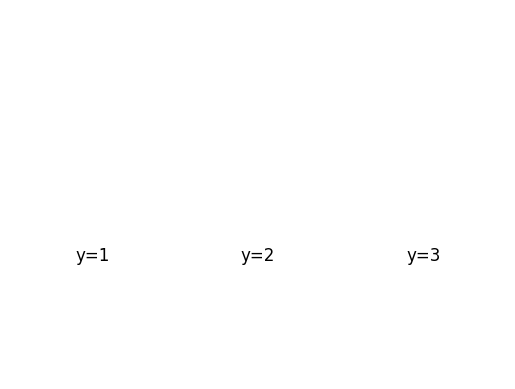

In [520]:
# Etiquetas y coordenadas para cada segmento
etiquetas = ['y=1', 'y=2', 'y=3']
coordenadas = [(2.5, 1), (7.5, 1), (12.5, 1)]

# Crear el gráfico y agregar las etiquetas de texto
for etiqueta, (x, y) in zip(etiquetas, coordenadas):
    plt.text(x, y, etiqueta, fontsize=12, color='black', ha='center', va='center')

# Configurar las dimensiones del gráfico
plt.xlim(0, 15)
plt.ylim(0, 3)

# Eliminar ejes y etiquetas
plt.axis('off')

# Mostrar el gráfico
plt.show()
